In [2]:
%matplotlib inline

import time
import sys
import os

import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn

import sklearn
import sklearn.metrics
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

# ML methods
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Raw data

In [3]:
raw = pandas.read_csv('./KB_data.csv')
raw[:2]

,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_range,opponent,shot_id
0,Jump Shot,-157,0,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),8-16 ft.,POR,2
1,Jump Shot,-101,135,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),16-24 ft.,POR,3


# Cleaning & Enriching


## Raw features

* shot_distance
* loc_x/y: Where on the court. Strong correlation with shot_distance,
* shot_zone_range: Redundant, categorical version of shot_distance
* shot_type: Seems only field goals are included, no penalty shots? Redundant, information is in shot_distance
* shot_zone_area: Rendant, informatino is in loc_x/loc_y
* opponent: Categorical. Approx 20 values
* combined_shot_type: Some correlation with shot_distance. Eg: Dunk always very close, Jump shots mostly far away
* minutes/seconds_remaining: In the period 
* period: Categorical
* season: Related to time (of career). 
* playoffs: 1/0. Different kind of game


In [8]:
preprocessed = raw.copy()

# MAYBE: Remove rare super longshots. But only for training, exists in compete set
# raw = raw[raw['shot_distance'] < 30.0]

# Tools

In [4]:
# Poor-mans GridSearchCV
def grid_search(estimator, grid, X, Y, splits=100, test_size=0.3, print_progress=True):
    pp = ParameterGrid(grid)
    
    results = []
    
    if print_progress:
        print('%d models with %d splits' % (len(pp), splits))
    
    # Calculate the best hyperparameters
    for model_idx, parameters in enumerate(pp):

        training_accuracies = []
        testing_accuracies = []
        for seed in range(0, splits):
            start_time = time.time()
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
            
            model = estimator(**parameters)
            model.fit(X_train, Y_train)
            
            Y_train_pred = model.predict(X_train)
            Y_test_pred = model.predict(X_test)
            
            train_score = sklearn.metrics.accuracy_score(Y_train, Y_train_pred) 
            test_score = sklearn.metrics.accuracy_score(Y_test, Y_test_pred)
            
            training_accuracies.append(train_score)
            testing_accuracies.append(test_score)
            end_time = time.time()
            if seed == 0:
                sys.stdout.write('\n %d/%d: %.2f(s) ' % (model_idx, len(pp), end_time-start_time))
            else:
                sys.stdout.write('.')
        
        # TODO: also return variance
        result = {
            'training_accuracy': numpy.average(training_accuracies),
            'testing_accuracy': numpy.average(testing_accuracies),
            'parameters': parameters,
        }
        results.append(result)

    # Select best result and retrain model on whole dataset
    by_accuracy = sorted(results, key=lambda r: r['testing_accuracy'], reverse=True)
    best_idx = results.index(by_accuracy[0])
    best_parameters = by_accuracy[0]['parameters']
    model = estimator(**best_parameters)
    model.fit(X, Y)
            
    return model, results, best_idx

## Model

In [35]:
def get_distance_class(bins, group):
    distance = group['shot_distance']
    distance_class = len(bins)
    for idx, edge in enumerate(bins[1:]):
        if distance < edge:
            distance_class = idx
            break
    #print('d', distance, distance_class)\n",
    return distance_class

# Returns a new categorical series
def feature_cross(data, feature_a, feature_b):
    def cross_value(a, b):
        v = "{}_{} X {}_{}".format(feature_a, a, feature_b, b)
        return v
    
    # possible combinations
    categories = []
    for a_cat in data[feature_a].cat.categories:
        for b_cat in data[feature_b].cat.categories:
            categories.append(cross_value(a_cat, b_cat))
    dtype = pandas.api.types.CategoricalDtype(categories=categories, ordered=False)
    
    def apply_cross(group):
        a,b = group[feature_a], group[feature_b]
        return cross_value(a, b)
        
    crossed = data.apply(apply_cross, axis=1).astype(dtype)
    return crossed


In [64]:
def linear_svc(**params):
    # C=1.0, penalty='l2'
    params['dual'] = False # 10x faster
    return LinearSVC(**params)

def random_forest(**params):
    # n_estimators=10, max_depth=None, max_features=’auto’, min_samples_split
    return RandomForestClassifier(**params)

def logit(**params):
     # C=1.0, penalty=’l2’ 
    return LogisticRegression(**params)

def radial_svc(**params):
    # C=1.0, gamma=’auto’
    params['kernel'] = 'rbf'
    return SVC(**params)

def kNN(**params):
    # p=2, n_neighbors=5
    return KNeighborsClassifier(**params)


alternatives = {
    'random_forest': {
        'n_estimators': [ 4, 8, 16, 32, 64 ],
        'min_samples_split': [ 0.1, 0.05, 0.01, 0.005, 0.003, ],
    },
    'logit': {
        'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0 ],
    },
    'kNN': {
        'n_neighbors': [ 5, 10, 15 ],
        'p': [ 2 ],
    },
    'linear_svc': {
        'C': [ 0.001, 0.01, 0.1, 0.5, 1.0, ],
        'tol': [ 0.000001, 0.00001, ],
        #'penalty': ['l2', 'l1'],
    },
    'radial_svc': {
        'C': [ 0.01, 0.05, 0.1, 0.2 ],
    }
}

In [65]:
def plot_results(res):
    training = map(lambda r: r['training_accuracy'], res)
    testing = map(lambda r: r['testing_accuracy'], res)
    
    param_names = res[0]['parameters'].keys()
    series = {}
    for name in param_names:
        values = list(map(lambda r: repr(r['parameters'][name]), res))
        series[name] = values
    
    # TODO: plot variance
    # TODO: plot heatmap
    
    series['training_score'] = list(training)
    series['testing_score'] = list(testing)
    
    df = pandas.DataFrame(series)
    #print(df)
    
    # .plot(figsize=(4,4), sharex=True, sharey=True)
    
    target = 0.616
    spread = 0.01
    # multiline plot with group by 
    def plot_score_trend(group_key, x_key):
        fig, (train_ax, test_ax) = plt.subplots(1, 2, figsize=(16, 6))
        train_ax.set_title("Training score")
        test_ax.set_title("Testing score")
        train_ax.set_xlabel(x_key)
        test_ax.set_xlabel(x_key)
        train_ax.set_ylim(target-spread, target+spread)
        test_ax.set_ylim(target-spread, target+spread)
        test_ax.axhline(y=target, color='black')
        train_ax.axhline(y=target, color='black')
        
        for val, group in df.groupby(group_key):
            label = '{}={}'.format(group_key, val)
            x = [ float(x) for x in group[x_key] ]
            train_ax.plot(list(x), list(group['training_score']), label=label)
            test_ax.plot(list(x), list(group['testing_score']), label=label)

        train_ax.legend()
        test_ax.legend()
        return fig

    first, second = param_names
    fig1 = plot_score_trend(first, second)
    fig2 = plot_score_trend(second, first)

    return fig1, fig2

In [70]:
class FeatureEncoder():

    def __init__(self, dist_bins):
        self.dist_bins = dist_bins
        b = list(range(len(dist_bins)+1))
        self.dist_dtype = pandas.api.types.CategoricalDtype(categories=b, ordered=True)
        
    def transform(self, data):
        time_remaining = (data['minutes_remaining'] * 60) + (data['seconds_remaining'])
        last_second = time_remaining < 30 # see quite a lot of desperate shots

        distance_class = data.apply(lambda g: get_distance_class(self.dist_bins, g), axis=1).astype(self.dist_dtype) 
        shot_distance_squared = data['shot_distance'] * data['shot_distance']
        
        injured_season = data['season'].isin(('2013-14', '2014-15', '2015-16'))
        # could calculate angle from loc_x/y. Less redundancy with shot_distance?
        # could try a better shot_distance estimator
        # could have left_court / right_court (/middle_court) based on loc_x or angle
        # could create feature crosses:
        #  shot_type X distance_class
        #  Opponent X distance_class ?
        #  Opponent X loc_x/angle
        #  (binned) loc_y X loc_bin_x
        
        shot_type = data['combined_shot_type'].astype('category')
        df = pandas.DataFrame({'type': shot_type, 'dist': distance_class})
        dist_type_cross = feature_cross(df, 'type', 'dist')
        
        features = pandas.DataFrame({
            'shot_type': shot_type,

            #'season': data['season'].astype('category'),
            'injured_season': injured_season,
            
            #'opponent': data['opponent'].astype('category'),
            #'playoffs': data['playoffs'].astype('category'),

            'last_second': last_second,
            #'time_remaining': time_remaining,
            'period': data['period'].astype('category'),
            
            'points': data['shot_type'].astype('category'),
            
            #'loc_x': data['loc_x'], 
            'shot_distance': data['shot_distance'],            
            'shot_distance_squared': shot_distance_squared,
            #'distance_class': distance_class,
            #'dist_type_cross': dist_type_cross,
        })
        
        scaled = set([
            'time_remaining', 'loc_x',
            'shot_distance', 'shot_distance_squared'
        ]).intersection(features.columns)
        if len(scaled):
            features[list(scaled)] = StandardScaler().fit_transform(features[list(scaled)])
        
        encoded = pandas.get_dummies(features, columns=None, drop_first=True)
        return encoded
    

q, dist_bins = pandas.qcut(preprocessed['shot_distance'], q=10, duplicates='drop', retbins=True)
encoder = FeatureEncoder(dist_bins)
usage_set = preprocessed[preprocessed['shot_made_flag'].notnull()]

encoded = encoder.transform(usage_set)
X = encoded
Y = usage_set['shot_made_flag'].astype(numpy.bool)
    
#encoded.shape
m = 'linear_svc'
best_model, r, best_idx = grid_search(locals()[m], alternatives[m], X, Y, splits=10)

r[best_idx]

14 models with 10 splits

 0/14: 0.19(s) .........
 1/14: 0.20(s) .........
 2/14: 0.24(s) .........
 3/14: 0.24(s) .........
 4/14: 0.26(s) .........
 5/14: 0.24(s) .........
 6/14: 0.26(s) .........
 7/14: 0.24(s) .........
 8/14: 0.30(s) .........
 9/14: 0.28(s) .........
 10/14: 0.32(s) .........
 11/14: 0.24(s) .........
 12/14: 0.33(s) .........
 13/14: 0.30(s) .........

{'parameters': {'C': 0.01, 'tol': 1e-06},
 'testing_accuracy': 0.6151851851851853,
 'training_accuracy': 0.615165320632291}

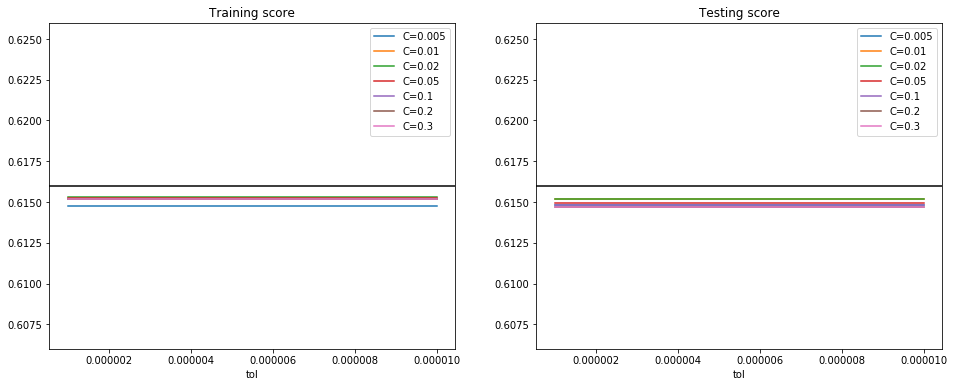

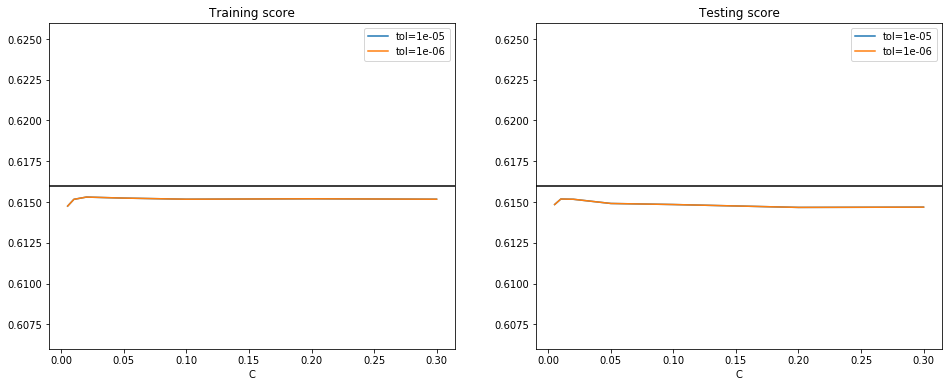

In [71]:
plot_results(r);

Feature ranking:
1. 10 : shot_type_Dunk (0.333286)
2. 2 : shot_distance_squared (0.291978)
3. 12 : shot_type_Jump Shot (0.190798)
4. 13 : shot_type_Layup (0.078733)
5. 1 : last_second (0.028121)
6. 5 : period_4 (0.022976)
7. 0 : injured_season (0.020809)
8. 9 : points_3PT Field Goal (0.011304)
9. 14 : shot_type_Tip Shot (0.007879)
10. 11 : shot_type_Hook Shot (0.005667)
11. 4 : period_3 (0.004582)
12. 6 : period_5 (0.002101)
13. 3 : period_2 (0.000740)
14. 7 : period_6 (0.000604)
15. 8 : period_7 (0.000423)


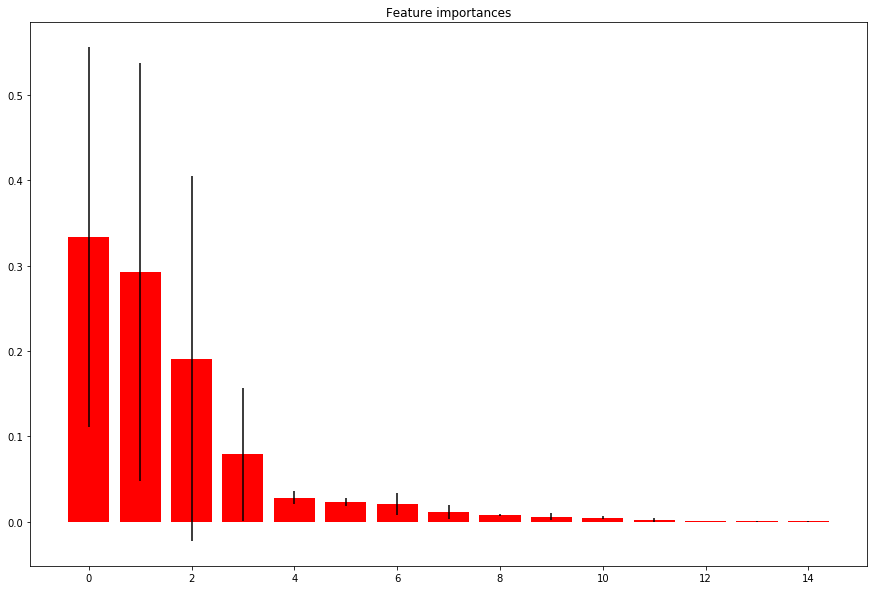

In [58]:
import numpy as np

def plot_forest_importance(forest):

    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. %d : %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]), )

    # Plot the feature importances of the forest
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title("Feature importances")
    ax.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    #ax.set_xticks(range(X.shape[1]), indices)
    #ax.set_xlim([-1, X.shape[1]])
    return fig

plot_forest_importance(best_model);


In [54]:
def make_submission(model, data):
    assert compete_set['shot_id'].shape[0] == 5000, compete_set.shape
    assert compete_set['shot_id'].values[0] == 4
    assert compete_set['shot_id'].values[-1] == 30693
    
    Y_comp = model.predict(data)
    
    out = compete_set.copy()
    out['shot_made_flag'] = Y_comp.astype(numpy.float)
    out.to_csv('./submission.csv', index=False, columns=['shot_id', 'shot_made_flag'])

compete_set = preprocessed[pandas.isna(preprocessed['shot_made_flag'])]
X_submit = encoder.transform(compete_set)
make_submission(best_model, X_submit)
#set(X_submit.columns).difference(X.columns), set(X.columns).difference(X_submit.columns)

# Data exploration

TRY? a dimenson reduction technique to get a feel for the data. PCA/PSLR ?


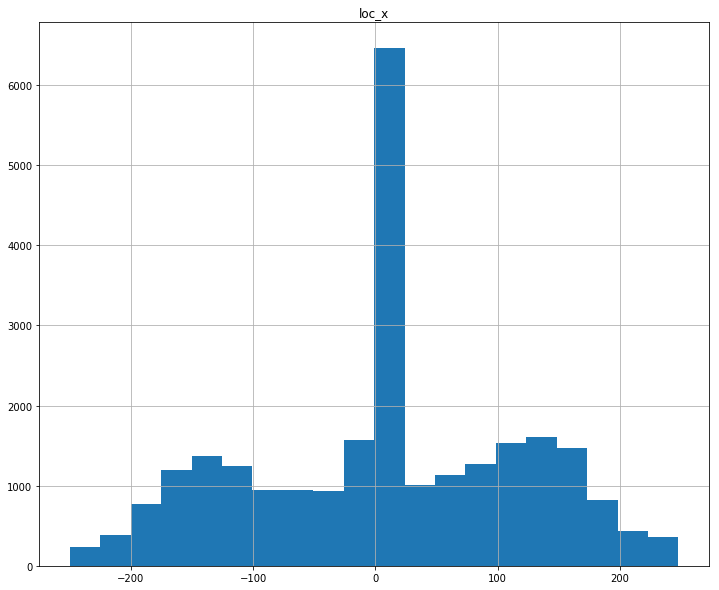

In [155]:
preprocessed.hist(column='loc_x', bins=20, figsize=(12,10), sharey=True);

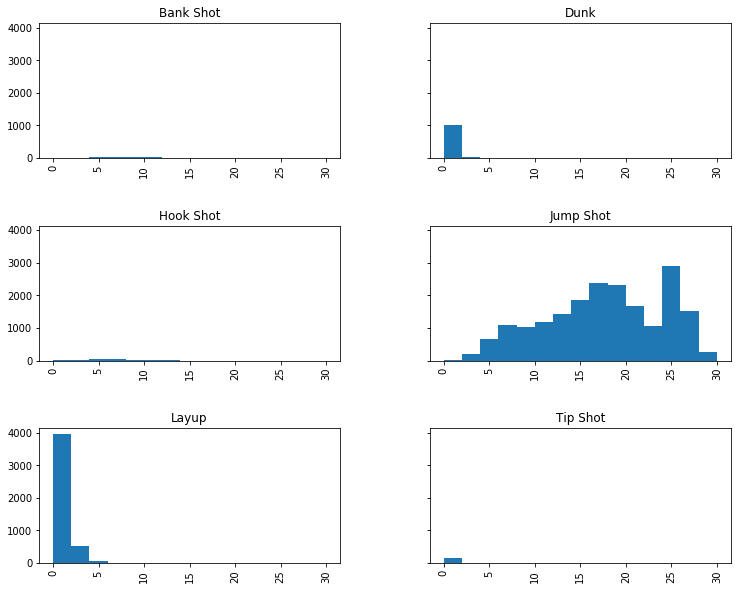

In [74]:
preprocessed.hist(column='shot_distance', by='combined_shot_type',
              bins=15, range=(0.0, 30.0), figsize=(12,10), sharey=True
);

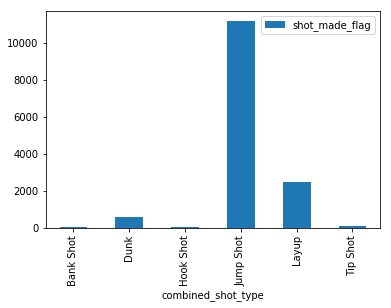

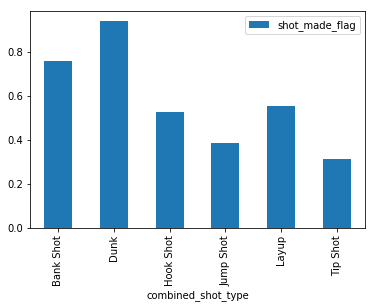

In [169]:
training.groupby(['combined_shot_type']).agg({'shot_made_flag': 'count'}).plot(kind='bar')
training.groupby(['combined_shot_type']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

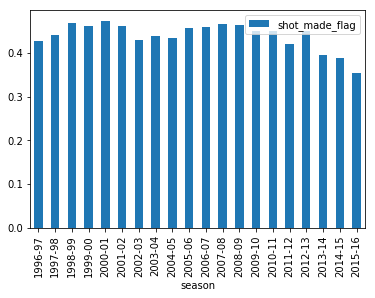

In [76]:
preprocessed.groupby(['season']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

In [82]:
# Last three seasons worse than the rest, otherwise small variations

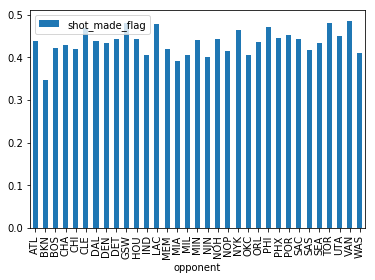

In [30]:
preprocessed.groupby(['opponent']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

In [ ]:
# BKN is an outlier, very few matches

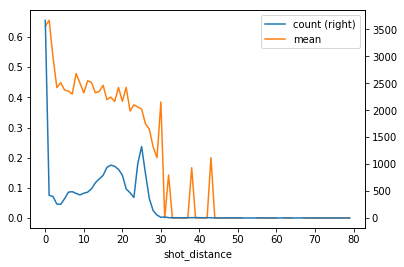

In [79]:
type_by_distance = preprocessed[preprocessed['combined_shot_type'] != '2Jump Shot'].groupby(['shot_distance'])
count = type_by_distance.agg({'shot_made_flag': 'count'})
mean = type_by_distance.agg({'shot_made_flag': 'mean'})
df = pandas.DataFrame({'count': count['shot_made_flag'], 'mean': mean['shot_made_flag']}, index=count.index)
df.plot(secondary_y='count')

In [181]:
data = encoded
data['distance_class'].value_counts()

KeyError: 'distance_class'

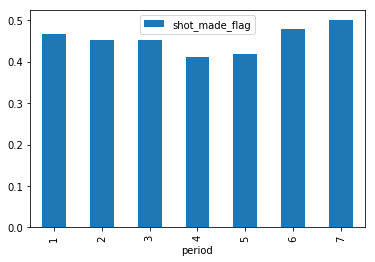

In [81]:
preprocessed.groupby(['period']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

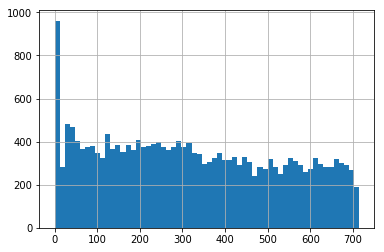

In [118]:
encoded['time_remaining'].hist(bins=60)

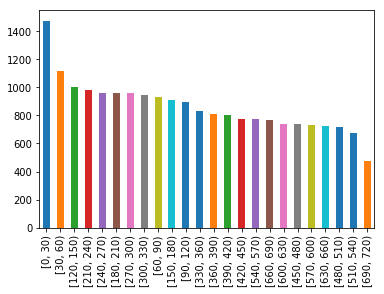

In [176]:
time_bins = np.arange(0, (60*12)+1, 30)
attempts_in_time = pandas.cut(encoded['time_remaining'], time_bins, right=False)
encoded['shot_made_flag'] = preprocessed['shot_made_flag']
grouped = encoded.groupby(attempts_in_time)
prec = grouped['shot_made_flag'].mean()
attempts_in_time.value_counts().plot(kind='bar')

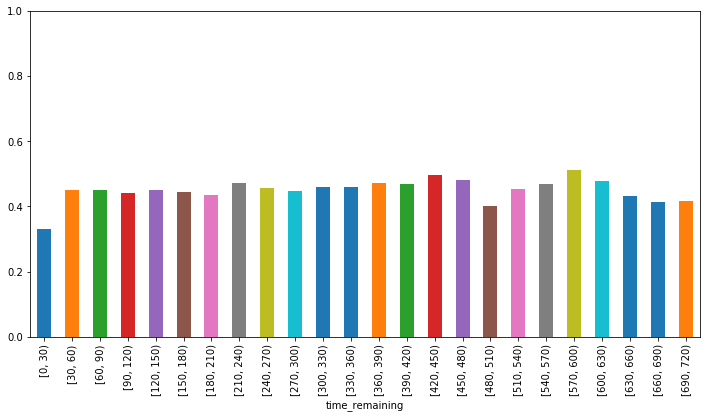

In [177]:
acc = prec.plot(kind='bar', figsize=(12, 6), ylim=(0.0, 1.0), title='')

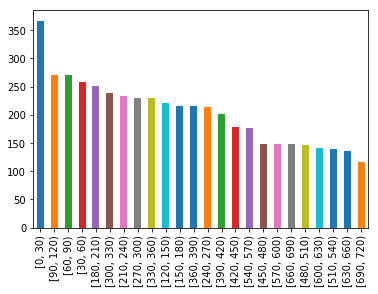

In [178]:
time_bins = np.arange(0, (60*12)+1, 30)
data = encoded[encoded['period_4'] == True]
data
attempts_in_time = pandas.cut(data['time_remaining'], time_bins, right=False)
grouped = data.groupby(attempts_in_time)
prec = grouped['shot_made_flag'].mean()
attempts_in_time.value_counts().plot(kind='bar')


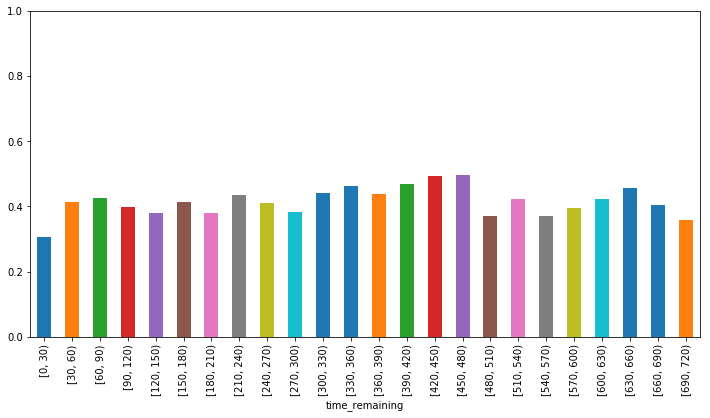

In [179]:
acc = prec.plot(kind='bar', figsize=(12, 6), ylim=(0.0, 1.0), title='')